In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import pandas as pd
import time
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from scipy import signal
from IPython.display import clear_output
import copy
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from keras.callbacks import LambdaCallback
import time
from matplotlib import gridspec
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
from tensorflow.keras import regularizers

linear2db = lambda x: 10*np.log10(x)
db2linear = lambda x: np.power(10,x/10)

N_max = 2**12

In [2]:
def createSignal(v = np.array([90, 100]), target_ratio = 2, f_c = 2e9, T = 100e-5, N = N_max, pad = 0, SNR = np.inf):

    c = 3e8                        # speed of light in m/s
    λ = c/f_c                      # wavelength of radar signal in meters

    N = int(N)
    n = np.linspace(0,N,N)
    # Compute amplitudes by the target ratio
    A = 1
    B = A*db2linear(target_ratio)

    # Comute doppler frequency
    f_d1 = (2*v[0]/λ)
    f_d2 = (2*v[1]/λ)

    #Compute doppler resolution
    dopplerResolution = 1 / (T*N)
    delta_f_Doppler = (2 * abs(v[1] - v[0])) / λ

    #Normalize the v
    v = list(map(lambda x: (x * λ) / T, v))

    #Compute siganl and pad it
    s = A*np.cos(2*np.pi*f_d1*n*T) + B*np.cos(2*np.pi*f_d2*n*T)

    '''
    #Complex form
    s = (A/2)*np.exp(1j*2*np.pi*f_d1*n*T) + (A/2)*np.exp(-1j*2*np.pi*f_d1*n*T) + \
        (B/2)*np.exp(1j*2*np.pi*f_d2*n*T) + (B/2)*np.exp(-1j*2*np.pi*f_d2*n*T)
    '''

    # Compute noise
    P_signal = np.mean(s**2)
    P_noise = P_signal /  db2linear(SNR)

    𝜖 = np.sqrt(P_noise) * np.random.randn(N)

    if SNR == np.inf:
        𝜖 = np.zeros(N)

    # Add noise to signal
    s += 𝜖

    return np.pad(s, int(pad), mode='constant', constant_values=0) , dopplerResolution, delta_f_Doppler

def plot_signal(s, db = False, title = ""):

    plt.figure(figsize = (18, 3))
    plt.title(title)

    if db:
        plt.plot(range(len(s)), np.abs(linear2db(s+ 1e-9)), 'cyan')
    else:
        plt.plot(range(len(s)), s, 'purple')

    plt.ylabel('Amplitude')
    plt.show()

def fft(s, hamming = True, double = True):
    if hamming:
        res = np.abs(np.fft.rfft(s*np.hamming(len(s))))
    else:
        res = np.abs(np.fft.rfft(s))

    if double:
      res = res[:-1]
      res = np.concatenate((res,res[::-1]))

    return res #/ np.max(res)


def isSeparate(dopplerResolution, delta_f_Doppler, threshold):
    return (delta_f_Doppler - threshold * dopplerResolution) > 0

def plotTrain(epochs, logs):

  train_loss.append(logs['loss'])
  test_loss.append(logs['val_loss'])

  preds = model.predict(X_test[indexes])
  reals = Y_test[indexes]
  input = X_test[indexes]

  fig = plt.figure(figsize=(15, 8))
  gs = gridspec.GridSpec(4, 2, figure=fig)
  clear_output(wait = True)
  for i, idx in enumerate(indexes):
      row = i // 2
      col = i % 2
      ax = fig.add_subplot(gs[row, col])

      #ax.plot(linear2db(reals[i] +1e-9), label="Targets", color = "gray")
      #ax.plot(linear2db(preds[i] +1e-9), label="Output", color = "black")
      #ax.plot(linear2db(fft(input[i]) + 1e-9), label="Bad", color = "red", alpha = 0.5)

      ax.plot(reals[i], label="Targets", color = "gray")
      ax.plot(preds[i], label="Output", color = "black")
      ax.plot(fft(input[i]), label="Bad", color = "red", alpha = 0.5)
      ax.legend()

  # Create a new plot that spans both columns in the last row
  ax_last = fig.add_subplot(gs[3, :])
  ax_last.plot(train_loss, label="train", color = "red")
  ax_last.plot(test_loss, label="test", color = "green")
  ax_last.legend()
  ax_last.grid()

  plt.tight_layout()
  plt.show()

In [3]:
def plot_beautiful_signal(signal, figsize = (18,3), title = "", db = False):

    signal = linear2db(signal + 1e-9) if db else signal
    num_points = len(signal) * 10
    x_smooth = np.linspace(0, len(signal) - 1, num_points)
    signal_smooth = np.interp(x_smooth, np.arange(len(signal)), signal)

    points = np.array([x_smooth, signal_smooth]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    fig, ax = plt.subplots(figsize = figsize)

    rainbow_colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#8B00FF']
    colors = np.linspace(0, 1, num_points)
    color_map = [to_rgba(color) for color in rainbow_colors]
    color_smooth = np.array([np.interp(colors, np.linspace(0, 1, len(color_map)), color) for color in zip(*color_map)]).T

    lc = LineCollection(segments, cmap='jet', colors=color_smooth)
    lc.set_array(signal_smooth)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)

    ax.set_xlim(0, len(signal) - 1)
    ax.set_ylim(np.min(signal) - 0.1, np.max(signal) + 0.1)

    cax = plt.colorbar(line, ax=ax, aspect=1000)
    cax.outline.set_visible(False)
    cax.set_ticks([])
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

100%|██████████| 729/729 [01:37<00:00,  7.44it/s]


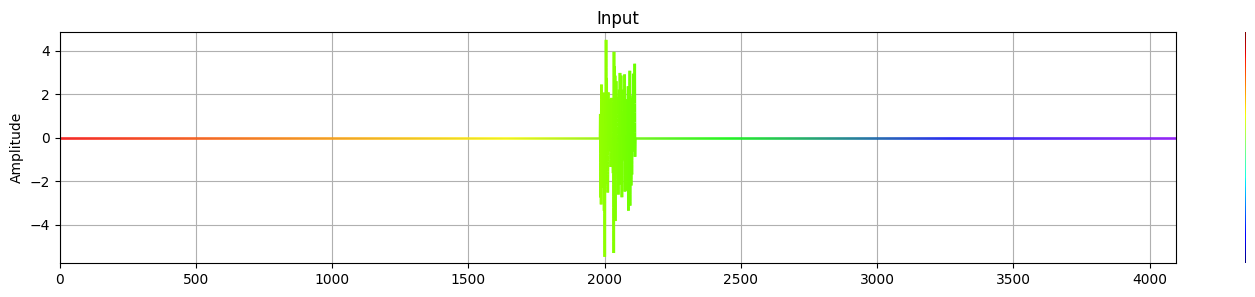

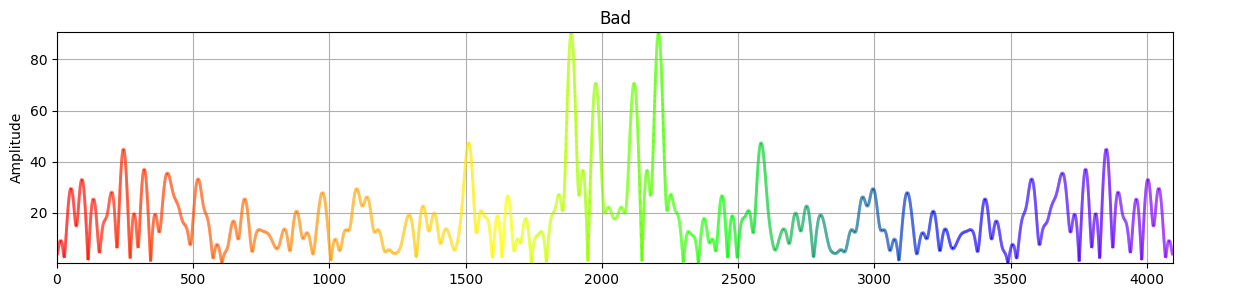

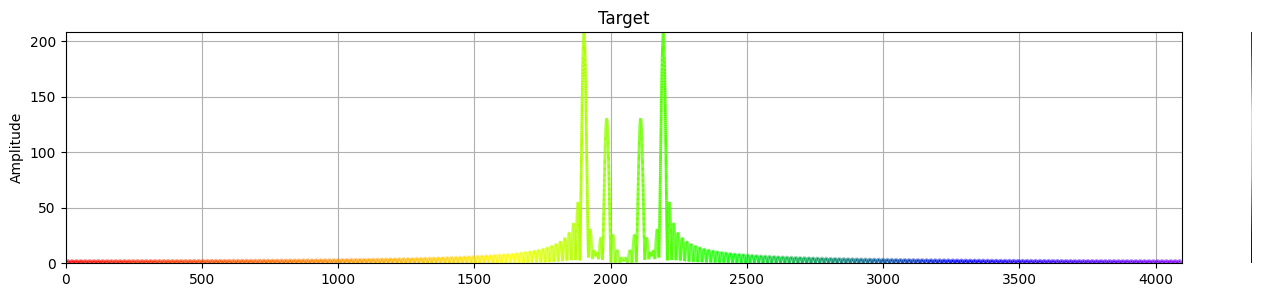

In [4]:
#Many pairs of velocity vectors

V1 = np.arange(50, 130, 3)
V2 = np.arange(50, 130, 3)

V1, V2 = np.meshgrid(V1, V2)
pairs = np.column_stack((V1.ravel(), V2.ravel()))

# Different values of PRI
T_values = np.arange(20,180,2)/1e5
N_values = 2**np.arange(6,12)

i = 0
X = []
Y = []
for pair in tqdm(pairs):
    for T_value in T_values:
        bad = []
        good = []
        for N_value in N_values:
            s, resolution, delta_f_Doppler = createSignal(v = pair, T = T_value, N = N_value, pad = (N_max - N_value)//2)
            #signal = s #{
                #"s": s ,
                #"resolution": resolution,
                #"delta_f_Doppler": delta_f_Doppler,
                #"T": T_value,
                #"N": N_value.astype(np.float64),
                #"V": pair.tolist()
            #}
            if isSeparate(resolution, delta_f_Doppler, 3):
                #signal["Good"] = 1

                good.append(s)
            else:
                #signal["Good"] = 0
                s, resolution, delta_f_Doppler = createSignal(v = pair, T = T_value, N = N_value, pad = (N_max - N_value)//2, SNR = -3)
                bad.append(s)
        if len(good)*len(bad) != 0:
            for signals in list(itertools.product(good, bad)):
                #data.append({"Good": fft(signals[0]),
                #           "Bad": signals[1]})
                X.append(signals[1])
                Y.append(fft(signals[0]))
                i +=1

X = np.vstack(X)
Y = np.vstack(Y)

#np.savetxt("X.csv", X, delimiter=",")
#np.savetxt("Y.csv", Y, delimiter=",")

i = np.random.randint(len(X))

plot_beautiful_signal(X[i,:], title = "Input")
plot_beautiful_signal(fft(X[i,:]), title = "Bad")
plot_beautiful_signal(Y[i,:], title = "Target")

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
del X,Y

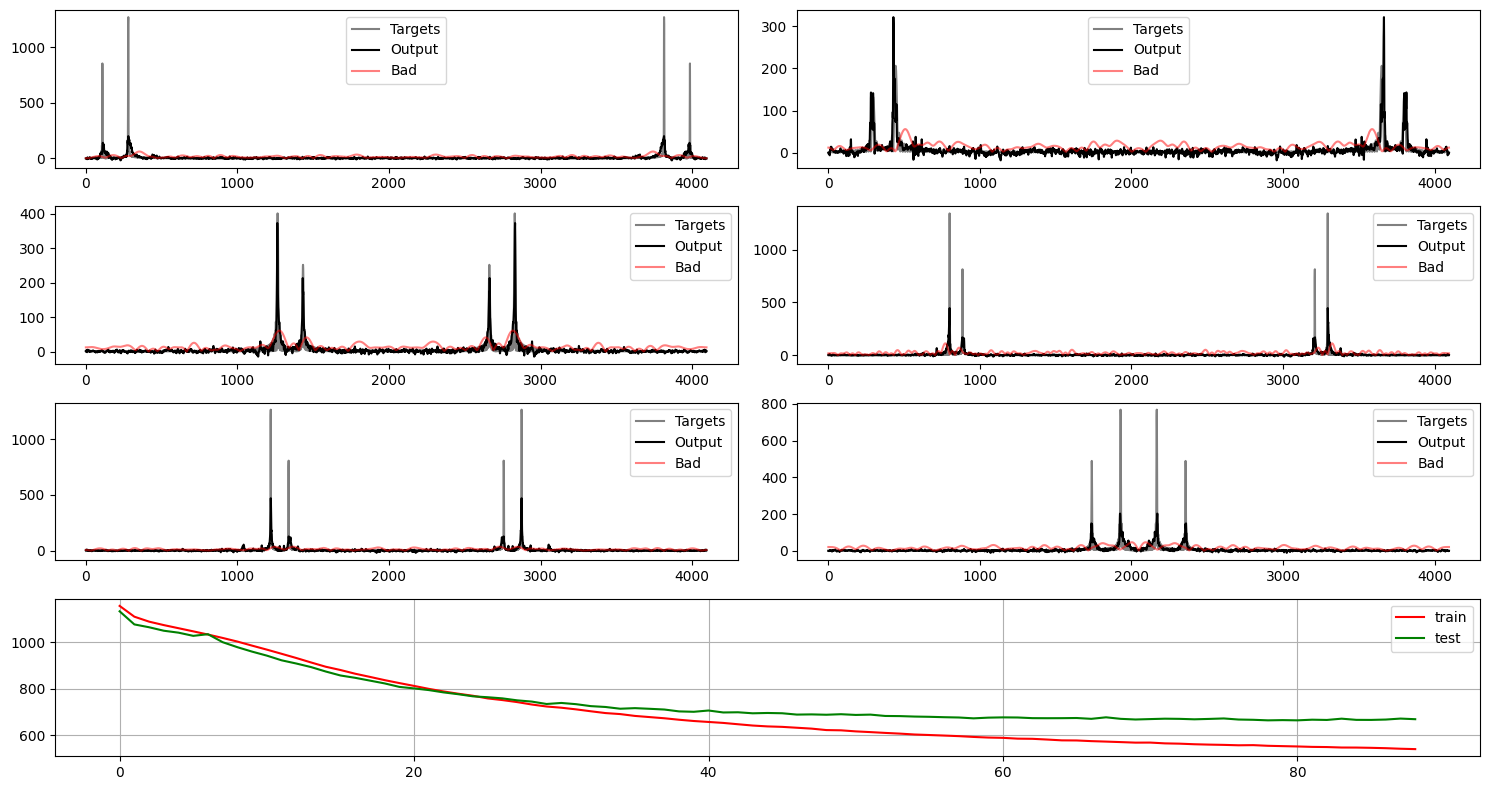

647/647 [==============================] - 31s 48ms/step - loss: 540.3412 - val_loss: 669.2375


In [6]:
indexes = np.random.randint(0, len(Y_test), 6)
train_loss = []
test_loss = []

input_dim, output_dim, input_sequence_length = 1, 1, N_max

#model = Sequential()
#model.add(LSTM(64, return_sequences=True, input_shape=(input_sequence_length, input_dim)))
#model.add(Dense(output_dim))

l2_strength = 0.0

model = tf.keras.Sequential([
    tf.keras.layers.Dense(N_max, input_shape=(N_max,), kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(N_max, kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(N_max, kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(N_max, kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(N_max, kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(N_max, kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(N_max, kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(N_max, kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(N_max, kernel_regularizer=regularizers.l2(l2_strength)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    # Final Output Layer
    tf.keras.layers.Dense(N_max)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

plot_callback = LambdaCallback(on_epoch_end=plotTrain)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test),callbacks=[plot_callback, early_stop])

In [10]:
X_test_sample = X_test[0][None, :]

# Define the number of times to run the prediction
num_iterations = 10000

# Run the prediction multiple times and store the timings
timings = []
for _ in tqdm(range(num_iterations)):
    start_time = time.time()
    predictions = model.predict(X_test_sample, verbose=0)
    end_time = time.time()

    # Calculate the time taken for the prediction
    time_taken = end_time - start_time
    timings.append(time_taken)

# Calculate the average time
average_time = sum(timings) / num_iterations

print("Average time taken for model.predict(): {:.4f} seconds".format(average_time))
print(f"The final loss is {np.mean((model.predict(X_test,verbose =0) - Y_test)**2):.2f}")


100%|██████████| 10000/10000 [10:47<00:00, 15.44it/s]


Average time taken for model.predict(): 0.0639 seconds
The final loss is 664.29


Block = fully connected + batch normalization (2 layers)
Remember that every network has also an output layer.

<br/>

| Blocks number   | Loss      | Run time (s) |
| :--------:      | :-------: | :------: |
| 1               | 778.93      |   0.0555    |
| 2               | 716.81         |  0.0560        |
| 3 | 710.06 | 0.0567
| 4 | 697.05 | 0.0568
| 5 | 671.25 | 0.0591
| 6 | 658.78 | 0.0620
| 7 | 655.86 | 0.0660
| 8 | 660.94 | 0.0663
| 9 | 664.29 | 0.0659

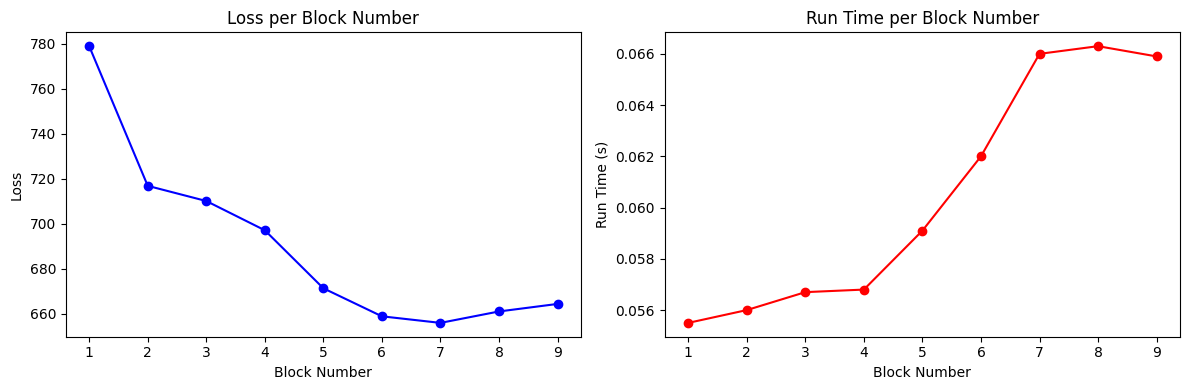

In [12]:
loss_values = [778.93, 716.81, 710.06, 697.05, 671.25, 658.78, 655.86, 660.94, 664.29]
run_times = [0.0555, 0.0560, 0.0567, 0.0568, 0.0591, 0.0620, 0.0660, 0.0663, 0.0659]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1,10), loss_values, marker='o', color='b')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Loss')
ax1.set_title('Loss per Block Number')

ax2.plot(range(1,10), run_times, marker='o', color='r')
ax2.set_xlabel('Block Number')
ax2.set_ylabel('Run Time (s)')
ax2.set_title('Run Time per Block Number')

plt.tight_layout()

plt.show()

In [9]:
'''
for _ in range(10):
  i = np.random.randint(0,len(Y_test))
  pred = model.predict(X_test[i][None,:], verbose = 0).squeeze()
  plot_beautiful_signal(fft(X_test[i]), figsize =(15,1), title = "Bad")
  plot_beautiful_signal(pred, figsize =(15,1), title = "Pred")
  plot_beautiful_signal(Y_test[i], figsize =(15,1), title = "True")
  time.sleep(4)
  clear_output(wait = True)
'''

'\nfor _ in range(10):\n  i = np.random.randint(0,len(Y_test))\n  pred = model.predict(X_test[i][None,:], verbose = 0).squeeze()\n  plot_beautiful_signal(fft(X_test[i]), figsize =(15,1), title = "Bad")\n  plot_beautiful_signal(pred, figsize =(15,1), title = "Pred")\n  plot_beautiful_signal(Y_test[i], figsize =(15,1), title = "True")\n  time.sleep(4)\n  clear_output(wait = True)\n'